<a href="https://www.kaggle.com/code/vedatgul/nlp-sentiment-analysis-with-amazon-kosmos-dataset?scriptVersionId=212738919" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

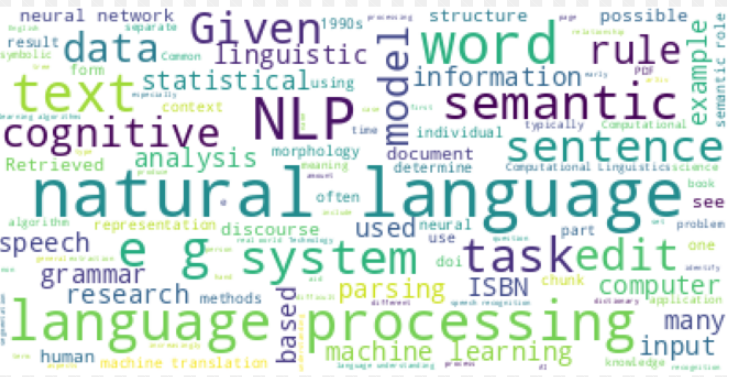

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong>Business Problem</strong></p>
    <p>Cosmos, which produces home textiles and daily wear-oriented products that sell through Amazon, increases its sales by analyzing the comments on its products and improving its features according to the complaints it receives.
        aims to increase. In line with this goal, the comments will be labeled by performing sentiment analysis and a classification model will be created with the labeled data.</p>

In [1]:
# Download the libraries if you don't have
!pip install nltk
!pip install twython
!pip install textblob
!pip install wordcloud
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from nltk.sentiment import SentimentIntensityAnalyzer
from warnings import filterwarnings

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.width', 400)

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong>Dataset Story</strong></p>
    <p>The data set consists of the comments made for a certain product group, the title of the comment, the number of stars and the variables that indicate how many people found the comment useful.

 **Star:** Number of stars given to the product
        
 **HelpFul:** Number of people who found the comment helpful
        
 **Title:** Title given to comment content, short comment
        
 **Review:** Comment on the product</p>

In [3]:
df=pd.read_csv("/kaggle/input/kozmos/kozmos.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5611 entries, 0 to 5610
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Star     5611 non-null   int64 
 1   HelpFul  5611 non-null   int64 
 2   Title    5559 non-null   object
 3   Review   5593 non-null   object
dtypes: int64(2), object(2)
memory usage: 175.5+ KB


In [5]:
df.head()

,Star,HelpFul,Title,Review
0,5,0,looks great,Happy with it
1,5,0,Pattern did not align between the two panels.,Good quality material however the panels are m...
2,5,0,Imagery is stretched. Still fun.,Product was fun for bedroom windows.<br />Imag...
3,5,0,Que se ven elegantes muy finas,Lo unico que me gustaria es que sean un poco ...
4,5,0,Wow great purchase,Great bang for the buck I can't believe the qu...


In [6]:
df.shape

(5611, 4)

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'> 1 |</span></b> <b>Text Preprocessing</b></div>

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong></strong></p>
   
**Convert Text to Lowercase:** Writing text entirely in lower case helps to avoid the difference between upper and lower case.

**Removing Punctuation:** Punctuation marks (periods, commas, exclamation marks, question marks, etc.) often add unnecessary noise to text.

**Replace Numbers with a Space:** You can replace numbers with a space character or other non-deterministic character.

**Removing stopwords:** Stop words, (e.g., "and", "or", "but", "that") are usually unimportant for text analysis and can therefore be removed.
 
**Tokenization:** Separating text at the sentence or word level breaks the text into smaller chunks and facilitates analysis.

**Lemmatisation:** These operations, called stemming operations, help to find the root of the word or convert the word to its dictionary meaning. For example, you can translate the word "running" into "run". to the word "word".</p>

In [7]:
# Convert Text to Lowercase
df['Review'] = df['Review'].str.lower()
df['Review'].head(10)

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windows.<br />imag...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i can't believe the qu...
5                           looks different then photo
6    was exactly what i was looking for. heavy mate...
7    looking at the picture, i thought these curtai...
8    much whiter than i thought it would be and was...
9    these are curtains just as the picture shows. ...
Name: Review, dtype: object

In [8]:
# Punctuations
df['Review'] = df['Review'].str.replace(r'[^\w\s]', '', regex=True)
df['Review'].head(10)

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windowsbr imagery ...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i cant believe the qua...
5                           looks different then photo
6    was exactly what i was looking for heavy mater...
7    looking at the picture i thought these curtain...
8    much whiter than i thought it would be and was...
9    these are curtains just as the picture shows t...
Name: Review, dtype: object

In [9]:
# Replace Numbers with a Space
df['Review']=df['Review'].str.replace('\d','',regex=True)
df['Review'].head(10)

0                                        happy with it
1    good quality material however the panels are m...
2    product was fun for bedroom windowsbr imagery ...
3     lo unico que me gustaria es que sean un poco ...
4    great bang for the buck i cant believe the qua...
5                           looks different then photo
6    was exactly what i was looking for heavy mater...
7    looking at the picture i thought these curtain...
8    much whiter than i thought it would be and was...
9    these are curtains just as the picture shows t...
Name: Review, dtype: object

In [10]:
# Stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')

In [11]:
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df['Review'].head(10)

0                                                happy
1      good quality material however panels mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria es que sean un poco mas ...
4    great bang buck cant believe quality material ...
5                                looks different photo
6    exactly looking heavy material great price shi...
7    looking picture thought curtains would thinner...
8    much whiter thought would wasnt really expecti...
9    curtains picture shows rd set ambesonne curtai...
Name: Review, dtype: object

In [12]:
# Rarewords
del_ = pd.Series(' '.join(df['Review']).split()).value_counts()[-1000:]
df['Review'] = df['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in del_))

In [13]:
# Lemmatization
nltk.download('punkt')
nltk.download('wordnet')
df['Review'] = df['Review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['Review'].head(10)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0                                                happy
1       good quality material however panel mismatched
2    product fun bedroom windowsbr imagery bit stre...
3    lo unico que gustaria e que sean un poco ma la...
4    great bang buck cant believe quality material ...
5                                 look different photo
6    exactly looking heavy material great price shi...
7    looking picture thought curtain would thinner ...
8    much whiter thought would wasnt really expecti...
9    curtain picture show rd set ambesonne curtain ...
Name: Review, dtype: object

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>2 |</span></b> <b>Data Visualisation</b></div>

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong></strong></p>
   
**Barplot:** Barplot is a type of graph used to visualise categorical data. It is often used to show frequencies or relationships of frequently occurring categorical values.

**Word Cloud:** Word Cloud is a type of chart used to visualise text data and highlight the importance of certain words. They are visually represented in different sizes and colours according to the frequency of the words in the text.</p>

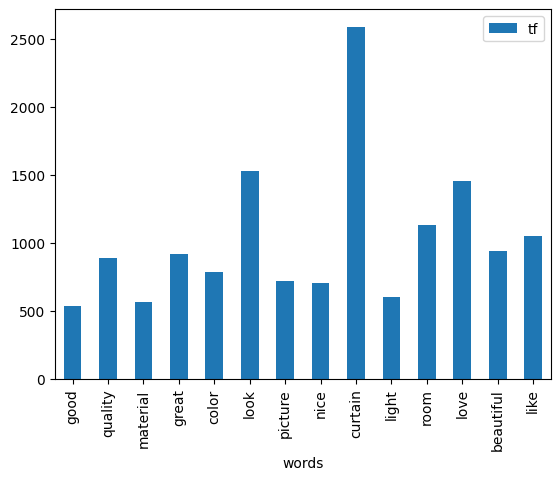

In [14]:
# Barplot
tf = df["Review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.columns = ["words", "tf"]
tf[tf["tf"] > 500].plot.bar(x="words", y="tf")
plt.show()

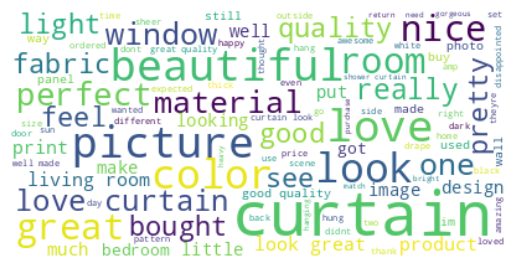

In [15]:
# Wordcloud
text = " ".join(i for i in df.Review)

wordcloud = WordCloud(max_font_size=50,
                      max_words=100,
                      background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b>Sentiment Analysis</b></div>

In [16]:
sia = SentimentIntensityAnalyzer()

In [17]:
df["Review"][0:10].apply(lambda x: sia.polarity_scores(x))

df["Review"][0:10].apply(lambda x: sia.polarity_scores(x)["compound"])

df["Review"][0:10].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df["Sentiment_Label"] = df["Review"].apply(lambda x: "pos" if sia.polarity_scores(x)["compound"] > 0 else "neg")

df.groupby("Sentiment_Label")["Star"].mean()

Sentiment_Label
neg   3.39
pos   4.59
Name: Star, dtype: float64

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>Modelling</b></div>


In [18]:
# Test-Train
train_x, test_x, train_y, test_y = train_test_split(df["Review"],
                                                    df["Sentiment_Label"],
                                                    random_state=42)

<div style="padding: 40px; background: radial-gradient(circle, #f5f7fa, #e2e9f0); border: 4px double #d1d8e0; border-radius: 30px; box-shadow: 0 10px 20px rgba(0,0,0,0.1); font-size: 120%; line-height: 1.9; color: #333; font-family: 'Georgia', serif; text-align: justify; position: relative;">
    <p style="color: #f39c12; font-size: 135%; border-left: 15px solid #3498db; padding-left: 20px; letter-spacing: 1px;"><strong></strong></p>
   
**TF-IDF Word Level** is a measure used to determine the importance of a term within a document, and this measure is based on the frequency of the term within the document and its prevalence across all documents.</p>

In [19]:
# TF-IDF Word Level
tf_idf_word_vectorizer = TfidfVectorizer().fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

In [20]:
# Modelling(Logistic Regression)
log_model = LogisticRegression().fit(x_train_tf_idf_word, train_y)
y_pred = log_model.predict(x_test_tf_idf_word)

print(classification_report(y_pred, test_y))

              precision    recall  f1-score   support

         neg       0.33      0.90      0.49        82
         pos       0.99      0.89      0.94      1321

    accuracy                           0.89      1403
   macro avg       0.66      0.89      0.71      1403
weighted avg       0.95      0.89      0.91      1403



In [21]:
# Cross Validation
cross_val_score(log_model, x_test_tf_idf_word, test_y, cv=5).mean()

0.8546034570411795

In [22]:
# Randomly selecting comments from the data and asking them to the model
random_review = pd.Series(df["Review"].sample(1).values)
new_comment = CountVectorizer().fit(train_x).transform(random_review)
pred = log_model.predict(new_comment)
print(f'Review:  {random_review[0]} \n Prediction: {pred}')

Review:  loved great material true coloring 
 Prediction: ['pos']


In [23]:
# Modelling (Random Forest)
rf_model = RandomForestClassifier().fit(x_train_tf_idf_word, train_y)
cross_val_score(rf_model, x_test_tf_idf_word, test_y, cv=5, n_jobs=-1).mean()

0.8916649720386376